# The Art of Life

Nature is remarkably complex and offers a plethora of intricate patterns to those who dare to investigate.
These patterns can appear in many forms. Here, we will take a look at how all (sequenced) organisms relate to each other when 
projecting their high-dimensional genome space down to two dimensions.

In [1]:
import os
import gzip
import json
import shutil
import functools
from pathlib import Path
import multiprocessing as mp
from concurrent.futures import Future, as_completed, ProcessPoolExecutor

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import requests
from requests_futures.sessions import FuturesSession

import khmer
import metagenompy
from Bio import SeqIO

import umap
import umap.plot

import joblib
from tqdm.auto import tqdm

In [2]:
%matplotlib inline
umap.plot.output_notebook()

Loading BokehJS ...

In [3]:
CPU_COUNT = 10
DATA_DIR = Path("genome_data")

## Retrieve Complete Genomes

Before analyzing the genomes, we need to download them. Here, we are going to download (a subset of) all genomes available on [RefSeq](https://www.ncbi.nlm.nih.gov/refseq/).

In [4]:
genome_dir = DATA_DIR / "genomes"
genome_dir.mkdir(parents=True, exist_ok=True)

In [5]:
# download assembly info
url = (
    "https://ftp.ncbi.nlm.nih.gov/genomes/ASSEMBLY_REPORTS/assembly_summary_refseq.txt"
)
path_assembly = DATA_DIR / "assembly_information.tsv"

if not path_assembly.exists():
    resp = requests.get(url, stream=True, allow_redirects=True)
    resp.raw.read = functools.partial(resp.raw.read, decode_content=True)
    with tqdm.wrapattr(resp.raw, "read", desc="Download assembly info") as resp_raw:
        with path_assembly.open("wb") as fd:
            shutil.copyfileobj(resp_raw, fd)

Download assembly info: 0it [00:00, ?it/s]

In [6]:
# parse assembly info
df_assembly = pd.read_csv(path_assembly, sep="\t", skiprows=1)

# cleaning
df_assembly.rename(
    columns={df_assembly.columns[0]: df_assembly.columns[0].lstrip("#").lstrip()},
    inplace=True,
)

# subsetting
df_assembly = df_assembly[
    (df_assembly["ftp_path"] != "na")
    & (df_assembly["genome_rep"] == "Full")
    & df_assembly["excluded_from_refseq"].isna()
    & (df_assembly["assembly_level"] == "Complete Genome")
]

# summary
print(df_assembly.shape)
df_assembly.head()

(36277, 23)


assembly_accession   bioproject     biosample wgs_master  \
18    GCF_000002515.2   PRJNA12377  SAMEA3138170        NaN   
24    GCF_000002725.2   PRJNA15564  SAMEA3138173        NaN   
25    GCF_000002765.5     PRJNA148  SAMN00102897        NaN   
34    GCF_000002985.6     PRJNA158  SAMEA3138177        NaN   
65    GCF_000005825.2  PRJNA224116  SAMN02603086        NaN   

          refseq_category   taxid  species_taxid  \
18  representative genome   28985          28985   
24  representative genome  347515           5664   
25  representative genome   36329           5833   
34       reference genome    6239           6239   
65                     na  398511          79885   

                          organism_name  infraspecific_name isolate  ...  \
18                 Kluyveromyces lactis  strain=NRRL Y-1140     NaN  ...   
24     Leishmania major strain Friedlin     strain=Friedlin     NaN  ...   
25            Plasmodium falciparum 3D7                 NaN     3D7  ...   
34               Caenorhabditis elegans   strain=Bristol N2     NaN  ...   
65  Alkalihalobacillus pseudofirmus OF4          strain=OF4     NaN  ...   

   genome_rep seq_rel_date       asm_name  \
18       Full   2004/07/02       ASM251v1   
24       Full   2011/02/14       ASM272v2   
25       Full   2016/04/07  GCA_000002765   
34       Full   2013/02/07       WBcel235   
65       Full   2010/12/15       ASM582v2   

                                            submitter  gbrs_paired_asm  \
18                             Genolevures Consortium  GCA_000002515.1   
24                                Friedlin Consortium  GCA_000002725.2   
25  Plasmodium falciparum Genome Sequencing Consor...  GCA_000002765.3   
34                   C. elegans Sequencing Consortium  GCA_000002985.3   
65  Center for Genomic Sciences, Allegheny-Singer ...  GCA_000005825.2   

   paired_asm_comp                                           ftp_path  \
18       different  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...   
24       identical  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...   
25       different  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...   
34       different  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...   
65       identical  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...   

   excluded_from_refseq relation_to_type_material asm_not_live_date  
18                  NaN                       NaN                na  
24                  NaN                       NaN                na  
25                  NaN                       NaN                na  
34                  NaN                       NaN                na  
65                  NaN                       NaN                na  

[5 rows x 23 columns]

In [7]:
def download_genome(row, target_dir, session):
    name = row.ftp_path.rsplit("/", 1)[-1]
    fname = f"{name}_genomic.fna.gz"

    path = target_dir / fname
    meta_path = f"{path}.json"

    url = f"{row.ftp_path}/{fname}"

    if path.exists():
        # print("Using cache for", url)
        future = Future()
        future.set_result("foo")
    else:
        # print("Downloading", url)
        future = session.get(url)

    future.path = path
    future.meta_path = meta_path
    future.accession = row.assembly_accession
    future.taxid = row.taxid

    return future

To speed up the download (which is IO bound), we will distribute this task over multiple threads.

In [8]:
with FuturesSession(max_workers=CPU_COUNT) as session:
    futures = df_assembly.apply(
        download_genome, axis=1, args=(genome_dir, session)
    ).tolist()

    for future in tqdm(
        as_completed(futures), total=len(futures), desc="Download genomes"
    ):
        resp = future.result()

        if isinstance(resp, requests.models.Response):
            with open(future.meta_path, "w") as fd:
                json.dump({"accession": future.accession, "taxid": future.taxid}, fd)

            with open(future.path, mode="wb") as fd:
                fd.write(resp.content)

Download genomes:   0%|          | 0/36277 [00:00<?, ?it/s]

## Compute Genomic Features

We are going to represent DNA sequences by their kmer count profile.
In addition, we will compute further statistics, such as, for example, the number of base pairs in each genome.

### Helper functions

In [9]:
def load_files(path):
    """Retrieve sequence and metadata for given entry."""
    with gzip.open(path, "rt") as fd:
        record_list = list(SeqIO.parse(fd, "fasta"))

    # aggregate sequences
    seq = ""
    for record in record_list:
        seq += str(record.seq)
    seq = seq.upper()

    # get metadata
    path_meta = f"{path}.json"
    with open(path_meta) as fd:
        metadata = json.load(fd)

    return seq, metadata

In [10]:
def compute_kmer_counts(seq, k=3):
    """
    https://github.com/dib-lab/khmer/blob/master/examples/python-api/exact-counting.py
    """
    # setup counter
    nkmers = 4 ** k
    tablesize = nkmers + 10

    cg = khmer.Countgraph(k, tablesize, 1)
    cg.set_use_bigcount(True)  # increase max count from 255 to 65535

    # count kmers
    cg.consume(seq)

    # return formatted output
    return {cg.reverse_hash(i): cg.get(i) for i in range(nkmers)}

In [11]:
def parse_entry(path):
    """Do all computations for single genome file."""
    assert str(path).endswith("_genomic.fna.gz"), path

    # parse entry
    seq, meta = load_files(path)

    # handle meta information
    meta["genome_size"] = len(seq)

    # count kerms
    kmer_counts = compute_kmer_counts(seq, k=5)

    return meta, kmer_counts

### Parse data

As computing these features is CPU bound, we are going to make use of multiprocessing.

In [12]:
kmer_data = {}
metadata = []

with ProcessPoolExecutor(
    max_workers=CPU_COUNT, mp_context=mp.get_context("fork")
) as executor:
    futures = [
        executor.submit(parse_entry, path)
        for path in genome_dir.iterdir()
        if str(path).endswith("_genomic.fna.gz")
    ]

    for future in tqdm(as_completed(futures), total=len(futures), desc="Parse genomes"):
        # compute stuff
        meta, kmer_counts = future.result()

        # keep results
        metadata.append(meta)
        id_ = meta["accession"]

        assert id_ not in kmer_data
        kmer_data[id_] = kmer_counts

Parse genomes:   0%|          | 0/36277 [00:00<?, ?it/s]

### Determine taxonomic lineage for each entry

To investigate how different types of organisms relate to each other, we will characterize each organisms by its [taxonomic rank](https://en.wikipedia.org/wiki/Taxonomic_rank).

In [13]:
# list of which ranks to consider
rank_list = ["species", "phylum", "clade", "kingdom", "superkingdom"]

In [14]:
graph = metagenompy.generate_taxonomy_network(auto_download=True)

Parsing nodes: 100%|██████████| 2388279/2388279 [00:21<00:00, 112286.89it/s]


In [15]:
df_meta = pd.DataFrame(metadata).set_index("accession")
df_meta["taxid"] = df_meta["taxid"].astype(str)

df_meta = metagenompy.classify_dataframe(graph, df_meta, rank_list=rank_list)

Classifying: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


### Save results

In [16]:
df_meta.to_csv(DATA_DIR / "metadata.csv.gz")
df_meta.head()

taxid  genome_size                   species  \
accession                                                         
GCF_002191655.1    29459      3312719       Brucella melitensis   
GCF_000852745.1   103881        17266  Potato yellow vein virus   
GCF_002197575.1  1983777        14964   Avian metaavulavirus 15   
GCF_006384535.1  2588128        59514       Gordonia phage Barb   
GCF_000025865.1   547558      2012424   Methanohalophilus mahii   

                          phylum                clade         kingdom  \
accession                                                               
GCF_002191655.1   Proteobacteria                 <NA>            <NA>   
GCF_000852745.1  Kitrinoviricota            Riboviria   Orthornavirae   
GCF_002197575.1  Negarnaviricota            Riboviria   Orthornavirae   
GCF_006384535.1      Uroviricota        Duplodnaviria  Heunggongvirae   
GCF_000025865.1    Euryarchaeota  Stenosarchaea group            <NA>   

                superkingdom  
accession                     
GCF_002191655.1     Bacteria  
GCF_000852745.1      Viruses  
GCF_002197575.1      Viruses  
GCF_006384535.1      Viruses  
GCF_000025865.1      Archaea

In [17]:
df_kmer = pd.DataFrame(kmer_data)
df_kmer.index.name = "kmer"

df_kmer.to_csv(DATA_DIR / "kmer_counts.csv.gz")
df_kmer.head()

GCF_002191655.1  GCF_000852745.1  GCF_002197575.1  GCF_006384535.1  \
kmer                                                                        
AAAAA             7574              120               51                3   
AAAAT             7646              160               63                6   
AAAAC             7884               72               33               11   
AAAAG             9115               77               29                4   
AAATA             4774              119               56               11   

       GCF_000025865.1  GCF_000019085.1  GCF_000800395.1  GCF_000861705.1  \
kmer                                                                        
AAAAA            15189            37345             2727               63   
AAAAT            11130            27333             1677               44   
AAAAC             7672            12339             2710               47   
AAAAG            10460            24769             3071               40   
AAATA             9577            21599             1022               19   

       GCF_000879055.1  GCF_014127105.1  ...  GCF_002448155.1  \
kmer                                     ...                    
AAAAA               13             6061  ...             1467   
AAAAT                8             6781  ...             1625   
AAAAC               11             7593  ...             3149   
AAAAG                7             7159  ...             2251   
AAATA               12             3594  ...             1328   

       GCF_016026895.1  GCF_003595175.1  GCF_019192625.1  GCF_018289355.1  \
kmer                                                                        
AAAAA            16316             4522            22659            36468   
AAAAT            11873             2734            17629            28855   
AAAAC            13131             4546            16801            19309   
AAAAG             6911             3583            12260            26820   
AAATA             6824             2166            11850            28194   

       GCF_007954485.1  GCF_016403105.1  GCF_011765625.1  GCF_900638255.1  \
kmer                                                                        
AAAAA            42322            12171            33204             7380   
AAAAT            34908            11573            28167             6670   
AAAAC            22568            10829            20225             8343   
AAAAG            23141             8646            18385             4012   
AAATA            27460             5007            23131             4916   

       GCF_015571675.1  
kmer                    
AAAAA            23280  
AAAAT            18076  
AAAAC            17542  
AAAAG            12757  
AAATA            11996  

[5 rows x 36277 columns]

## Data overview

Before analyzing the data in more depth, we check whether reasonable kmer counts have been generated and whether the taxonomic classification worked out.

In [18]:
# did the kmer counting work
max_count_fraction = (df_kmer >= 65535).sum().sum() / (
    df_kmer.shape[0] * df_kmer.shape[1]
)
print(f"{max_count_fraction * 100:.2f}% of kmer counts have reached numeric maximum")

0.08% of kmer counts have reached numeric maximum


In [19]:
# how many NAs are in our taxonomic metadata
df_meta.isna().sum()

taxid               0
genome_size         0
species            27
phylum           2041
clade           15606
kingdom         26965
superkingdom       27
dtype: int64

Additionally, we can briefly look at some interesting summary statistics.

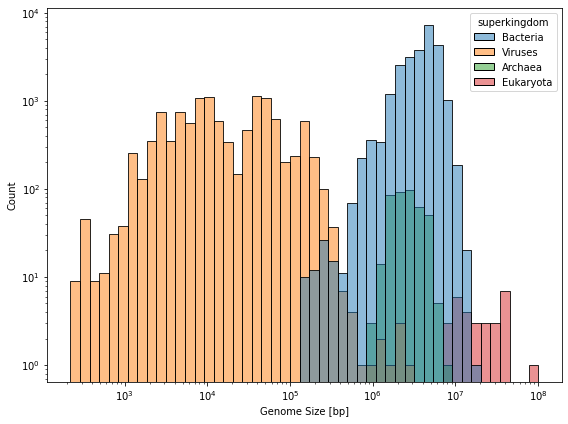

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=df_meta, x="genome_size", hue="superkingdom", log_scale=True, ax=ax)

ax.set_xlabel("Genome Size [bp]")
ax.set_yscale("log")

fig.tight_layout()
fig.savefig(DATA_DIR / "genome_size_hist.pdf")

## Kmer statistics

Before reducing the dimensionality of the kmer space, let's look at a few of its features.

Let's start by checking the overall kmer count distribution. We can observe a peak at $0$ as well as a peak at the numeric kmer count maximum of $65535$.

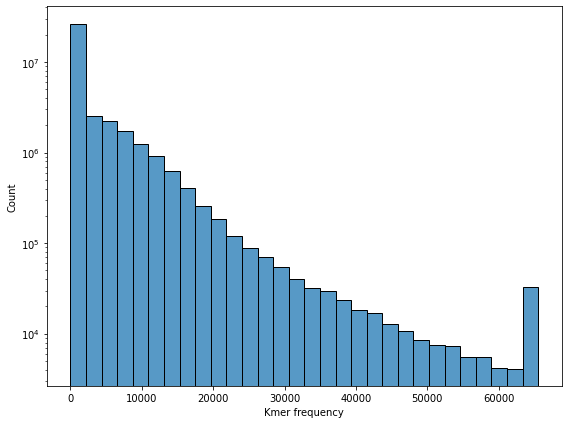

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=df_kmer.values.ravel(), bins=30, ax=ax)

ax.set_xlabel("Kmer frequency")
ax.set_yscale("log")

fig.tight_layout()
fig.savefig(DATA_DIR / "kmer_count_hist.pdf")

We then continue by looking at the most/least common kmers averaged over all organisms.

In [22]:
kmer_counts = df_kmer.median(axis=1)
kmer_counts = kmer_counts[kmer_counts > 0]

print("Most common kmers:")
print(kmer_counts.head())
print()
print("Least common (non-zero) kmers:")
print(kmer_counts.tail())

Most common kmers:
kmer
AAAAA    8464.0
AAAAT    6449.0
AAAAC    6518.0
AAAAG    6762.0
AAATA    4391.0
dtype: float64

Least common (non-zero) kmers:
kmer
GCCCC    2177.0
GCCGC    3081.0
GCGCC    2676.0
GGACC    1526.0
GGCCC    1114.0
dtype: float64


Finally, we can enjoy a clustered heatmap.

/cluster/work/bewi/nss/apps/gcc-6.3.0/conda/4.8.3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


CPU times: user 2min 40s, sys: 6.02 s, total: 2min 46s
Wall time: 2min 47s


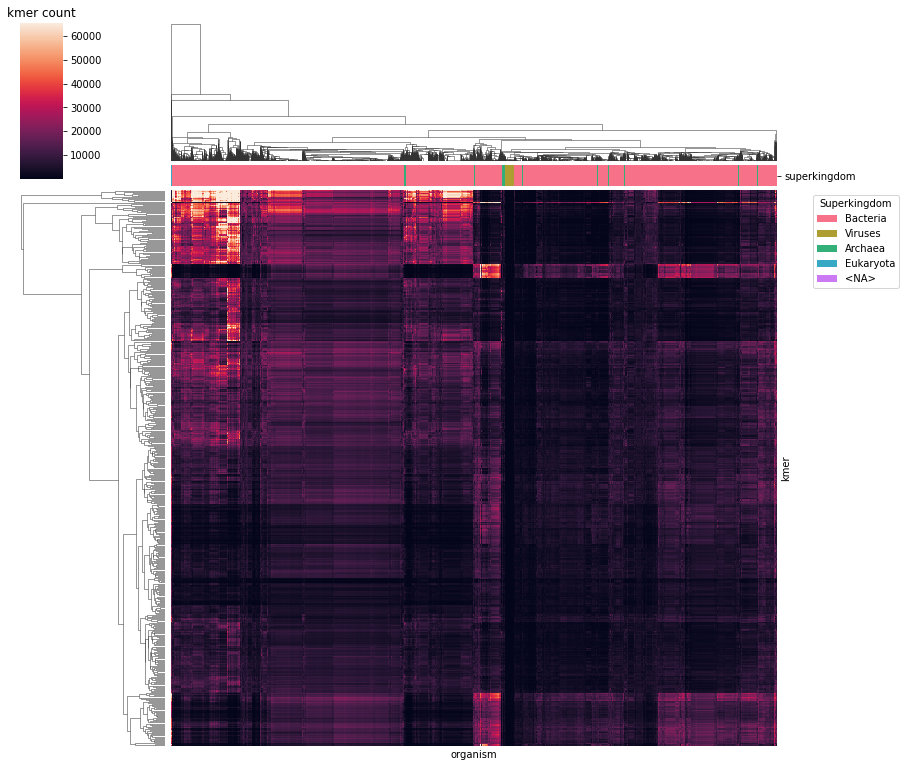

In [23]:
%%time

# retain rows with non-zero entries and columns with not-low entries
df_kmer_sub = df_kmer.loc[(df_kmer > 0).any(axis=1), (df_kmer.median(axis=0) > 10)]
df_kmer_sub.columns.rename("organism", inplace=True)

# generate column color map
rank_colors = {
    rank: sns.color_palette("husl", df_meta["superkingdom"].nunique(dropna=False))[i]
    for i, rank in enumerate(df_meta["superkingdom"].unique())
}
rank_cmap = df_meta.loc[df_kmer_sub.columns, "superkingdom"].map(rank_colors)

# create plot
g = sns.clustermap(
    df_kmer_sub,
    col_colors=rank_cmap,
    rasterized=True,
    figsize=(12, 12),
)

g.cax.set_title("kmer count")
g.ax_heatmap.tick_params(bottom=False, labelbottom=False, right=False, labelright=False)

g.ax_heatmap.legend(
    handles=[Patch(facecolor=color, label=name) for name, color in rank_colors.items()],
    title="Superkingdom",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

fig.savefig(DATA_DIR / "kmer_heatmap.pdf", dpi=300)

## Visualize Projected Genome Space

Finally, we can project the high-dimensional kmer space to two dimensions and explore its topology.

In [24]:
reducer = umap.UMAP(
    metric="cosine",
    random_state=42,
    low_memory=True,
    verbose=True,
    n_neighbors=100,
    n_jobs=min(CPU_COUNT, 8),
)

In [25]:
reducer.fit(df_kmer.T)

UMAP(angular_rp_forest=True, metric='cosine', n_jobs=8, n_neighbors=100, random_state=42, verbose=True)
Wed Jan  5 23:36:01 2022 Construct fuzzy simplicial set
Wed Jan  5 23:36:01 2022 Finding Nearest Neighbors
Wed Jan  5 23:36:01 2022 Building RP forest with 15 trees
Wed Jan  5 23:36:06 2022 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Wed Jan  5 23:37:06 2022 Finished Nearest Neighbor Search
Wed Jan  5 23:37:11 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed Jan  5 23:38:22 2022 Finished embedding


UMAP(angular_rp_forest=True, metric='cosine', n_jobs=8, n_neighbors=100, random_state=42, verbose=True)

In [26]:
joblib.dump(reducer, DATA_DIR / "umap_model.joblib")

Wed Jan  5 23:38:27 2022 Worst tree score: 0.96907131
Wed Jan  5 23:38:27 2022 Mean tree score: 0.97277063
Wed Jan  5 23:38:27 2022 Best tree score: 0.97499793
Wed Jan  5 23:38:37 2022 Forward diversification reduced edges from 3627700 to 258377
Wed Jan  5 23:38:40 2022 Reverse diversification reduced edges from 258377 to 257088


/cluster/home/kimja/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Wed Jan  5 23:38:42 2022 Degree pruning reduced edges from 297740 to 297717
Wed Jan  5 23:38:42 2022 Resorting data and graph based on tree order
Wed Jan  5 23:38:42 2022 Building and compiling search function


['genome_data/umap_model.joblib']

### Static visualization

We can look at a static image...

In [27]:
def format_taxonomy_string(taxonomy, rank_list=["superkingdom", "kingdom"]):
    """Convert classification columns to readable string."""
    return ";".join(str(taxonomy[rank]) for rank in rank_list)

In [28]:
embedding = reducer.transform(df_kmer.T)

df_umap = pd.DataFrame(embedding)
df_umap.columns = ("UMAP0", "UMAP1")
df_umap["accession"] = df_kmer.columns

df_umap["taxonomic_rank"] = df_umap["accession"].apply(
    lambda x: format_taxonomy_string(df_meta.loc[x], rank_list=["superkingdom"])
)

df_umap.set_index("accession", inplace=True)
df_umap["genome_size"] = df_meta["genome_size"]

df_umap.to_csv(DATA_DIR / "umap.csv.gz")
print(df_umap.shape)
df_umap.head()

(36277, 4)


UMAP0     UMAP1 taxonomic_rank  genome_size
accession                                                       
GCF_002191655.1  18.933571  1.356702       Bacteria      3312719
GCF_000852745.1   7.202410  5.276213        Viruses        17266
GCF_002197575.1   7.665549  3.549558        Viruses        14964
GCF_006384535.1  17.502321 -1.682356        Viruses        59514
GCF_000025865.1   8.906975  5.523824        Archaea      2012424

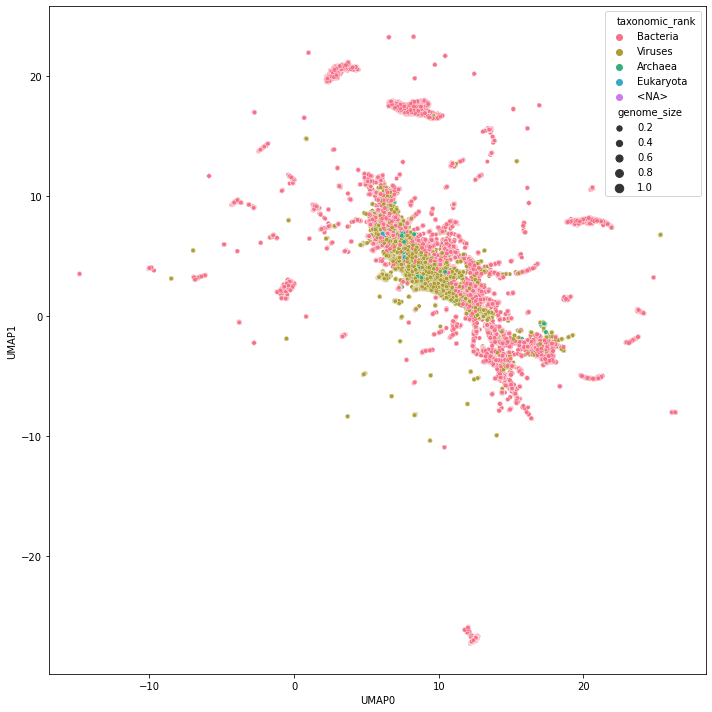

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
    data=df_umap,
    x="UMAP0",
    y="UMAP1",
    hue="taxonomic_rank",
    size="genome_size",
    rasterized=True,
    palette=sns.color_palette("husl", df_umap["taxonomic_rank"].nunique()),
    ax=ax,
)

fig.tight_layout()
fig.savefig(DATA_DIR / "umap.pdf", dpi=300)

### Interactive visualization

...but also pan and zoom around in an interactive view.

In [30]:
hover_data = df_meta.loc[df_kmer.columns].rename_axis("accession").reset_index()

hover_data["genome_size"] = hover_data["genome_size"].apply(lambda x: f"{x:,} bp")

In [31]:
p = umap.plot.interactive(
    reducer,
    labels=df_umap["taxonomic_rank"].reset_index(drop=True),
    theme="fire",
    hover_data=hover_data,
    point_size=2,
)
umap.plot.show(p)